In [1]:
import os
import time
import numpy as np

from simtk import unit
from simtk.openmm import app, LangevinIntegrator
from simtk.openmm.app import PDBFile

import parmed as pmd

import matplotlib.pyplot as plt
import mpld3

# Choose underlying toolkits
Choose the toolkit(s) you want to use with the OpenFF toolkit (either OpenEye or Ambertools and RDKit)

In [2]:
from openforcefield.utils import toolkits

### OpenEye version: uncomment the following if you have and if you want to use the OpenEye toolkit, then RDKit and Ambertools toolkits
# toolkit_precedence = [toolkits.OpenEyeToolkitWrapper, toolkits.RDKitToolkitWrapper, toolkits.AmberToolsToolkitWrapper]

### Non-OpenEye version: uncomment the following if you want to use the rdkit and ambertools
toolkit_precedence = [toolkits.RDKitToolkitWrapper, toolkits.AmberToolsToolkitWrapper]

toolkits.GLOBAL_TOOLKIT_REGISTRY = toolkits.ToolkitRegistry(toolkit_precedence=toolkit_precedence)

In [3]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

In [4]:
# choose the force field:
# not yet the release version!
openff_forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

In [5]:
# function to convert openFF molecule (ligand) to a parmed structure
def ligandToPMD(ligand):
    ligand_positions = ligand.conformers[0]
    
    # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
    try:
        ligand.compute_partial_charges_am1bcc()
    except Exception as e:
        raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
    # Give all atoms unique names so we can export to GROMACS
    for idx, atom in enumerate(ligand.atoms):
        atom.name = f'{atom.element.symbol}{idx}'
    
    # Do not assign H-bond constraints now, instead have ParmEd add them later
    del openff_forcefield._parameter_handlers['Constraints']

    ligand_topology = ligand.to_topology()
    try:
        ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
    except Exception as e:
        raise Exception('Error in creating openmm system: {}'.format(e))
    # Create OpenMM Topology from OpenFF Topology
    omm_top = ligand_topology.to_openmm()


    # Convert OpenMM System to a ParmEd structure.
    pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)

    return pmd_structure, ligand_topology, ligand_system, ligand_positions

In [6]:
# function for analyzing energy contributions of openMM energies
def forcegroupify(system):
    forcegroups = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        force.setForceGroup(i)
        forcegroups[(type(force)).__name__] = i
    return forcegroups

def getEnergyDecomposition(context, forcegroups):
    energies = {}
    for f, i in forcegroups.items():
        energies[f] = context.getState(getEnergy=True, groups=2**i).getPotentialEnergy()
    energies['TotalPotential'] = context.getState(getEnergy=True).getPotentialEnergy()
    return energies

# Create gromacs topologies and coordinates of simple test molecules

In [7]:
# create simple test molecules
target = 'testmols'
print('=== ' + target + ' ===')
names = ['methane', 'ethane', 'ethanol', 'acetone', 'benzene', 'phenol', 'benzaldehyde']
smiles = ['C', 'CC', 'CCO', 'CC(=O)C', 'c1ccccc1', 'c1ccccc1O', 'c1ccccc1C=O']
for lig, smi in zip(names, smiles):
    print('    ', lig)
    ligand = Molecule.from_smiles(smi)
    ligand.name = lig
    ligand.generate_conformers()
    
    ligPath = 'systems/' + target + '/' + lig 
    ! mkdir -p $ligPath
    ligPath += '/' + lig
    
    # Export sdf file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
    try: 
        pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
    except Exception as e:
        print('    ' + str(e))
        continue
       
    # Export GROMACS files.
    pmd_structure.save(ligPath+'.top', overwrite=True)
    pmd_structure.save(ligPath+'.gro', overwrite=True)

=== testmols ===
     methane


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'methane' has more than one conformer, but this function will only generate charges for the first one.


     ethane


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'ethane' has more than one conformer, but this function will only generate charges for the first one.


     ethanol


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'ethanol' has more than one conformer, but this function will only generate charges for the first one.


     acetone


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'acetone' has more than one conformer, but this function will only generate charges for the first one.


     benzene
     phenol
     benzaldehyde


# Convert pdb files to gromacs topologies

In the last version I first converted the pdb files first to sdf with OpenBabel - let the OpenFF toolkit (only works with OpenEye) do the conversion. If the OpenEye toolkit is not available, (preconverted) SDF files are used instead

ATTENTION: Using PDB files might prone to errors because the pdb files do not have bond information

In [8]:
for target in ['jnk1', 'pde2', 'thrombin']:
    print('=== ' + target + ' ===')
    ligands = ! ls -d "systems/"$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath= 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath + '.pdb'):
            print('   ', lig[-2])
            
            # Try to read in PDB file (original), only works with OpenEye
            # Otherwise the SDF file (not original, converted from PDB) is used
            try:
                ligand = Molecule.from_file(ligPath + '.pdb')
                # save as sdf file
                ligand.to_file(ligPath+'.sdf', 'sdf')
            except Exception as e:
                print('    ' + str(e))
                if os.path.isfile(ligPath + '.sdf'):
                    print('    Using the SDF file')
                    ligand = Molecule.from_file(ligPath + '.sdf')
                else:
                    print('    Molecules {} cannot be read in'.format(lig[-2]))
            
            try: 
                pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
            except Exception as e:
                print('    ' + str(e))
                continue

            # Export GROMACS files.
            pmd_structure.save(ligPath+'.top', overwrite=True)
            pmd_structure.save(ligPath+'.gro', overwrite=True)

=== jnk1 ===
    lig_17124-1
    No toolkits in registry can read file systems/jnk1/lig_17124-1/lig_17124-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18624-1
    No toolkits in registry can read file systems/jnk1/lig_18624-1/lig_18624-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18625-1
    No toolkits in registry can read file systems/jnk1/lig_18625-1/lig_18625-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18626-1
    No toolkits in registry can read file systems/jnk1/lig_18626-1/lig_18626-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig

    lig_49580115
    No toolkits in registry can read file systems/pde2/lig_49580115/lig_49580115.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_49582390
    No toolkits in registry can read file systems/pde2/lig_49582390/lig_49582390.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_49582468
    No toolkits in registry can read file systems/pde2/lig_49582468/lig_49582468.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_49585367
    No toolkits in registry can read file systems/pde2/lig_49585367/lig_49585367.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_

# Use SDF files with coordinates of PDB files

This only works for the PDE2 ligands. SDF file of supporting information of https://www.nature.com/articles/s41598-018-23039-5
Here, sometimes warnings ("duplicate atom") pop up (not reproducible). To be investigated.

In [9]:
print('=== pde2_sdf ===')
target = 'pde2_sdf'
ligands = Molecule.from_file('systems/pde2_sdf/4D08_ligands_input.sdf', 'sdf')
for ligand in ligands:
    # try to find a pdb matching the ligand from the SDF file
    pdbtarget = 'pde2'
    pdbligands = ! ls -d 'systems/'$pdbtarget/*/
    for pdblig in pdbligands:
        pdblig = pdblig.split('/')
        pdbligPath = 'systems/' + pdbtarget + '/' + pdblig[-2] + '/' + pdblig[-2]
        
        if os.path.isfile(pdbligPath+'.pdb'):
            pdb = app.PDBFile(pdbligPath + ".pdb")
            openmm_topology = pdb.topology
            try:
                ligand_topology = Topology.from_openmm(openmm_topology, unique_molecules=[ligand])
                print('    {}    {}'.format(ligand.name, pdblig[-2]))
                break
            except:
                continue
    else:
        print('PDB coordinates not found')
    
    
    # the following try statement is a custom version of the function ligandToPMD above
    try:
        # get pdb positions
        ligand_positions = pdb.getPositions()
            
        # set ligand conformer to pdb positions, Attention: This only works if the order of atoms is the same in the pdb file and the ligand class
        ligand.conformers[0] = unit.Quantity(np.array(ligand_positions.value_in_unit(unit.angstrom)), unit.angstrom)
            
        # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
        try:
            ligand.compute_partial_charges_am1bcc()
        except Exception as e:
            raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
        # Give all atoms unique names so we can export to GROMACS
        for idx, atom in enumerate(ligand.atoms):
            atom.name = f'{atom.element.symbol}{idx}'
            ligand_topology.atom(idx).atom.name = atom.name

        # Do not assign H-bond constraints now, instead have ParmEd add them later
        del openff_forcefield._parameter_handlers['Constraints']

        try:
            ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
        except Exception as e:
            raise Exception('Error in creating openmm system: {}'.format(e))
        # Create OpenMM Topology from OpenFF Topology
        omm_top = ligand_topology.to_openmm()


        # Convert OpenMM System to a ParmEd structure.
        pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)
    except Exception as e:
        print('    ' + str(e))
        continue

    # Output path.
    ligPath = 'systems/' + target + '/' + pdblig[-2]
    ! mkdir -p $ligPath
    ligPath = 'systems/' + target + '/' + pdblig[-2] + '/' + pdblig[-2]
        
    # Export single SDF file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
    # Export GROMACS files.        
    pmd_structure.save(ligPath+'.top', overwrite=True)
    pmd_structure.save(ligPath+'.gro', overwrite=True)

=== pde2_sdf ===


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   48  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  , HETATM   30  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    2    lig_43249674


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   31  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  , HETATM    1  H   Q2T A1918      -3.091  22.411  18.274  0.00 18.25           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   48  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  , HETATM   31  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: 

    4    lig_49137530
    6    lig_48009208
    7    lig_48022468
    8    lig_48168913
    9    lig_49137374
    10    lig_48271249


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   33  C   Q2T A1918      -5.453  22.635  17.072  0.00  0.00           C  , HETATM    6  C   Q2T A1918      -0.096  21.639  19.622  0.00 18.14           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -5.421  21.581  16.797  0.00  0.00           H  , HETATM   54  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: 

    11    lig_49220392
    12    lig_49580115
    13    lig_49220548
    14    lig_49396360
    15    lig_49175828
    16    lig_49072088


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  , HETATM   51  C   Q2T A1918      -5.107  25.522  17.600  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   53  C   Q2T A1918      -5.531  25.378  19.038  0.00  0.00           C  , HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: 

    17    lig_49582468


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -3.585  21.519  17.446  0.00  0.00           H  , HETATM   55  H   Q2T A1918      -2.900  22.990  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    18    lig_49932129
    19    lig_49932714
    20    lig_49585367
    21    lig_49175789


/opt/anaconda3/envs/off-demo/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:536: UserWarning: WARNING: duplicate atom (HETATM   60  H   Q2T A1918      -3.584  21.515  17.446  0.00  0.00           H  , HETATM   59  H   Q2T A1918      -2.901  22.988  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    22    lig_50181001
    23    lig_50107616
    24    lig_49582390


# Run single point energies and minimizations in openMM and Gromacs

In [10]:
# initialize dicts to store gromacs and openMM energies
gromacsEnergies = {}
openmmEnergies = {}
gromacsMinimizedEnergies = {}
openmmMinimizedEnergies = {}

#### openMM

In [11]:
 # run it in openMM
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    openmmEnergies[target] = {}
    openmmMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gro_positions = pmd.load_file(ligPath + '.gro')
            
            ligand_topology = pmd.load_file(ligPath + '.top', box = gro_positions.box)
            ligand_system = ligand_topology.createSystem(nonbondedMethod = app.NoCutoff, removeCMMotion = False)

            integrator = LangevinIntegrator(300*unit.kelvin, 
                            1/unit.picosecond, 
                            0.002*unit.picoseconds)

             
            simulation = app.Simulation(ligand_topology, ligand_system, integrator)
        
            simulation.context.setPositions(gro_positions.positions)
        
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmEnergies[target][lig[-2]] = energies
            print('     Estart : {}'.format(energies['TotalPotential']))
    
            simulation.minimizeEnergy()
            minimized_coords = simulation.context.getState(getPositions=True).getPositions()
            
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmMinimizedEnergies[target][lig[-2]] = energies
            print('     Emin   : {}'.format(energies['TotalPotential']))

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
     Estart : -56.58201744737174 kJ/mol
     Emin   : -73.8825684590909 kJ/mol
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
     Estart : 71.52773971628957 kJ/mol
     Emin   : 55.6714660818017 kJ/mol
------------------------------------------------------------
--- benzene ---
------------------------------------------------------------
     Estart : 41.460562777381696 kJ/mol
     Emin   : 23.455973386337362 kJ/mol
------------------------------------------------------------
--- ethane ---
------------------------------------------------------------
     Estart : 24.275584284827417 kJ/mol
     Emin   : 4.434348078241473 kJ/mol
------------------------------------------------------------
--- ethanol ---
-----------------------------------

     Estart : 328.63734891583886 kJ/mol
     Emin   : 224.22594333639609 kJ/mol
------------------------------------------------------------
--- lig_49175789 ---
------------------------------------------------------------
     Estart : 314.3884388786692 kJ/mol
     Emin   : 191.6395365875522 kJ/mol
------------------------------------------------------------
--- lig_49175828 ---
------------------------------------------------------------
     Estart : 283.441304893188 kJ/mol
     Emin   : 165.587722380189 kJ/mol
------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
     Estart : 294.0847147322063 kJ/mol
     Emin   : 178.37201591896388 kJ/mol
------------------------------------------------------------
--- lig_49220548 ---
------------------------------------------------------------
     Estart : 305.47542521018704 kJ/mol
     Emin   : 190.72342244579278 kJ/mol
-----------------------------------

     Estart : 321.00687773774047 kJ/mol
     Emin   : 224.16106862819132 kJ/mol
------------------------------------------------------------
--- lig_49580115 ---
------------------------------------------------------------
     Estart : 323.32569670389296 kJ/mol
     Emin   : 213.02123169033442 kJ/mol
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
     Estart : 504.8921524421573 kJ/mol
     Emin   : 372.8930199255004 kJ/mol
------------------------------------------------------------
--- lig_49582468 ---
------------------------------------------------------------
     Estart : 164.46255377504673 kJ/mol
     Emin   : 42.2283730098799 kJ/mol
------------------------------------------------------------
--- lig_49585367 ---
------------------------------------------------------------
     Estart : 358.80600249503476 kJ/mol
     Emin   : 235.41661054521103 kJ/mol
--------------------------------

#### Gromacs

Run Gromacs to get energies
Needed to have some sleep times between the system calls because writing of files was not yet finished.
Important to have the option -maxwarn 1 in grompp, because Gromacs sometimes gives warnings about unconstrained quickly oscillating bonds and consequently does not write files. It is important to turn of constraints in the Gromacs input files.

In [12]:
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    gromacsEnergies[target] = {}
    gromacsMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            dir = 'systems/' + target + '/' + lig[-2]
            ! rm -f $dir/\#*
            
            # single point energy of starting structure
            energies = ''
            count = 0
            while not energies and count < 10:
                print('    Calculate single-point energy ...')
                os.system("gmx grompp -f ./input/gromacs/md.mdp -c {}.gro -p {}.top -o {}_md.tpr -maxwarn 1 &> {}_grompp.out".format(ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                os.system("gmx mdrun  -s {}_md.tpr -rerun {}.gro -e {}.edr -g {}.log &> {}_mdrun.out".format(ligPath, ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                energies = ! cat $ligPath'.log' | grep -A 4 "Energies"
                count += 1
            ene_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(energies)-1)/2)):
                keys = [s.strip() for s in energies[1+i*2].split('  ') if s]
                values = energies[2+i*2].split()
                for key, val in zip(keys, values):
                    ene_dict[key] = float(val)
            print('    ' + str(ene_dict))
            gromacsEnergies[target][lig[-2]] = ene_dict
                        
            # energy minimization
            minEnergies = ''
            count = 0
            while not minEnergies and count < 10:
                print('    Energy minimize ligand ...')
                os.system("gmx grompp -f ./input/gromacs/minim.mdp -c {}.gro -p {}.top -o {}_em.tpr -maxwarn 1 &> {}_grompp_em.out".format(ligPath, ligPath, ligPath, ligPath))
                os.system("gmx mdrun  -deffnm {}_em &> {}_mdrun_em.out".format(ligPath, ligPath))
                time.sleep(2)
                # getting the last energies entry
                minEnergies = ! tac $ligPath'_em.log' | grep -m 1 -B 4 "Energies" | tac 
                count += 1
            
            minEne_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(minEnergies)-1)/2)):
                keys = [s.strip() for s in minEnergies[1+i*2].split('  ') if s]
                values = minEnergies[2+i*2].split()
                for key, val in zip(keys, values):
                    minEne_dict[key] = float(val)
            print('    ' + str(minEne_dict))
            gromacsMinimizedEnergies[target][lig[-2]] = minEne_dict

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 10.3407, 'Angle': 6.06319, 'Proper Dih.': 22.0362, 'LJ-14': 1.99935, 'Coulomb-14': -110.627, 'LJ (SR)': -0.327426, 'Coulomb (SR)': 13.9331, 'Potential': -56.582}
    Energy minimize ligand ...
    {'Bond': 0.251402, 'Angle': 3.20018, 'Proper Dih.': 21.8385, 'LJ-14': 1.87911, 'Coulomb-14': -110.324, 'LJ (SR)': -0.3291, 'Coulomb (SR)': 14.0032, 'Potential': 0.0, 'Potential Pressure (bar)': -69.481}
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 5.53898, 'Angle': 6.66067, 'Proper Dih.': 0.0191611, 'LJ-14': 21.275, 'Coulomb-14': 46.5636, 'LJ (SR)': -0.694336, 'Coulomb (SR)': -7.83531, 'Potential': 71.5277}
    Energy minimize ligand ...
    {'

    {'Bond': 5.28956, 'Angle': 34.307, 'Proper Dih.': 26.2732, 'LJ-14': 58.3157, 'Coulomb-14': -2739.4, 'LJ (SR)': -16.0659, 'Coulomb (SR)': 1521.36, 'Potential': 0.0, 'Potential Pressure (bar)': -1109.92}
------------------------------------------------------------
--- lig_18630-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 17.0204, 'Angle': 39.0794, 'Proper Dih.': 25.3956, 'LJ-14': 59.8271, 'Coulomb-14': -2723.86, 'LJ (SR)': -15.966, 'Coulomb (SR)': 1508.12, 'Potential': -1090.38}
    Energy minimize ligand ...
    {'Bond': 5.73933, 'Angle': 33.6773, 'Proper Dih.': 25.7172, 'LJ-14': 59.1419, 'Coulomb-14': -2723.53, 'LJ (SR)': -15.8667, 'Coulomb (SR)': 1508.62, 'Potential': 0.0, 'Potential Pressure (bar)': -1106.5}
------------------------------------------------------------
--- lig_18631-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 26.8532, 

    {'Bond': 11.1271, 'Angle': 62.1674, 'Proper Dih.': 39.7539, 'LJ-14': 64.5298, 'Coulomb-14': -3373.18, 'LJ (SR)': -18.5256, 'Coulomb (SR)': 1637.44, 'Potential': 0.0, 'Potential Pressure (bar)': -1576.69}
=== pde2 ===
------------------------------------------------------------
--- lig_43249674 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 48.6123, 'Angle': 119.051, 'Proper Dih.': 30.1194, 'LJ-14': 74.7191, 'Coulomb-14': 138.783, 'LJ (SR)': -25.8714, 'Coulomb (SR)': -83.6309, 'Potential': 301.782}
    Energy minimize ligand ...
    {'Bond': 8.80165, 'Angle': 103.06, 'Proper Dih.': 30.4677, 'LJ-14': 69.8951, 'Coulomb-14': 138.309, 'LJ (SR)': -26.4793, 'Coulomb (SR)': -82.5795, 'Potential': 0.0, 'Potential Pressure (bar)': 241.475}
------------------------------------------------------------
--- lig_48009208 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'

    {'Bond': 52.7236, 'Angle': 128.059, 'Proper Dih.': 42.3353, 'LJ-14': 76.4171, 'Coulomb-14': 188.797, 'LJ (SR)': -27.6125, 'Coulomb (SR)': -136.206, 'Potential': 324.514}
    Energy minimize ligand ...
    {'Bond': 11.2772, 'Angle': 112.399, 'Proper Dih.': 42.4256, 'LJ-14': 74.2927, 'Coulomb-14': 188.105, 'LJ (SR)': -27.5331, 'Coulomb (SR)': -135.36, 'Potential': 0.0, 'Potential Pressure (bar)': 265.607}
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 57.5829, 'Angle': 140.79, 'Proper Dih.': 82.7952, 'LJ-14': 78.7593, 'Coulomb-14': 239.304, 'LJ (SR)': -29.4653, 'Coulomb (SR)': -164.288, 'Potential': 506.541, 'Improper Dih.': 101.062}
    Energy minimize ligand ...
    {'Bond': 11.1758, 'Angle': 115.91, 'Proper Dih.': 83.0464, 'LJ-14': 76.2633, 'Coulomb-14': 237.87, 'LJ (SR)': -29.436, 'Coulomb (SR)': -163.403, 'Potential': 0.0, 'Improper D

    Calculate single-point energy ...
    {'Bond': 9.41534, 'Angle': 37.5006, 'Proper Dih.': 68.9482, 'LJ-14': 42.1093, 'Coulomb-14': 967.478, 'LJ (SR)': -33.427, 'Coulomb (SR)': -772.869, 'Potential': 319.155}
    Energy minimize ligand ...
    {'Bond': 6.81041, 'Angle': 32.4393, 'Proper Dih.': 68.6413, 'LJ-14': 43.0719, 'Coulomb-14': 960.63, 'LJ (SR)': -33.0607, 'Coulomb (SR)': -771.863, 'Potential': 0.0, 'Potential Pressure (bar)': 306.67}
------------------------------------------------------------
--- lig_6a ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 9.37007, 'Angle': 37.5759, 'Proper Dih.': 69.082, 'LJ-14': 44.6477, 'Coulomb-14': 967.803, 'LJ (SR)': -32.5437, 'Coulomb (SR)': -776.438, 'Potential': 319.497}
    Energy minimize ligand ...
    {'Bond': 6.64819, 'Angle': 32.5388, 'Proper Dih.': 68.8248, 'LJ-14': 45.3789, 'Coulomb-14': 961.348, 'LJ (SR)': -32.8658, 'Coulomb (SR)': -775.799, 'Potential': 0.0, 'Pot

    Calculate single-point energy ...
    {'Bond': 60.2339, 'Angle': 127.506, 'Proper Dih.': 47.8157, 'LJ-14': 81.9558, 'Coulomb-14': 95.5063, 'LJ (SR)': -25.9723, 'Coulomb (SR)': -104.708, 'Potential': 282.338}
    Energy minimize ligand ...
    {'Bond': 10.8149, 'Angle': 114.386, 'Proper Dih.': 48.0248, 'LJ-14': 77.2542, 'Coulomb-14': 94.6257, 'LJ (SR)': -26.5608, 'Coulomb (SR)': -103.531, 'Potential': 0.0, 'Potential Pressure (bar)': 215.014}
------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 60.5761, 'Angle': 126.648, 'Proper Dih.': 39.2396, 'LJ-14': 78.6108, 'Coulomb-14': 136.605, 'LJ (SR)': -26.618, 'Coulomb (SR)': -121.509, 'Potential': 293.553}
    Energy minimize ligand ...
    {'Bond': 10.589, 'Angle': 113.859, 'Proper Dih.': 39.3358, 'LJ-14': 74.2979, 'Coulomb-14': 135.876, 'LJ (SR)': -27.0126, 'Coulomb (SR)': -120.388, 'Potential': 0

# Summarize results

#### Single point energies
The PeriodicTorsionForce of openMM is sometimes split up to 'Proper Dih.' and 'Improper Dih.' energies in Gromacs. A higher precision comparison does not make sense because the Gromacs values only have 6 digit precision.

In [13]:
energies={}
differing_molecules = []
print('    {:20s}: {:15s}    {:15s}    {:15s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    energies[target] = {}
    for key in openmmEnergies[target].keys():
        print(key)
        energies[target][key] = {}
        for kk, ene in openmmEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsEnergies[target][key]['Proper Dih.']
                if 'Improper Dih.' in gromacsMinimizedEnergies[target][key].keys():
                    print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format('ImproperTorsionForce', 0.0, gromacsMinimizedEnergies[target][key]['Improper Dih.'], -gromacsMinimizedEnergies[target][key]['Improper Dih.']))
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsEnergies[target][key]['Potential']
            else:
                gromacs_ene = 0.0
                print('Error: OpenMM Energy not known: ' + kk)
            totdiff = ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene
            if np.fabs(totdiff) > 1e-2:
                differing_molecules.append([target, key])
            energies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM             Gromacs            Difference     
=== testmols ===
acetone
    HarmonicBondForce   :     1.03407e+01        1.03407e+01       -3.17147e-05
    HarmonicAngleForce  :     6.06319e+00        6.06319e+00       -1.15338e-06
    PeriodicTorsionForce:     2.20362e+01        2.20362e+01       -3.04307e-05
    NonbondedForce      :    -9.50220e+01       -9.50220e+01       -6.81486e-05
    TotalPotential      :    -5.65820e+01       -5.65820e+01       -1.74474e-05
benzaldehyde
    HarmonicBondForce   :     5.53899e+00        5.53898e+00        1.40617e-05
    HarmonicAngleForce  :     6.66065e+00        6.66067e+00       -2.06574e-05
    PeriodicTorsionForce:     1.91610e-02        1.91611e-02       -1.46143e-07
    NonbondedForce      :     5.93089e+01        5.93090e+01       -1.86419e-05
    TotalPotential      :     7.15277e+01        7.15277e+01        3.97163e-05
benzene
    HarmonicBondForce   :     8.88870e+00        8.88871e+00       -1.1250

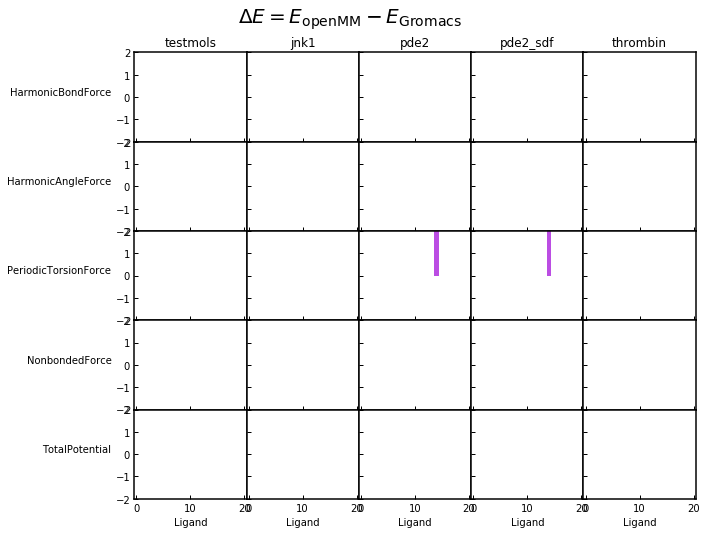

In [14]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(energies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], energies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], energies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_differences_openmm_gromacs.png')
plt.show()

#### Molecules with deviation > 0.01 kJ/mol in one of the terms

=== pde2 ===
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    HarmonicBondForce   :     5.75828e+01        5.75829e+01       -1.47136e-04
    HarmonicAngleForce  :     1.40790e+02        1.40790e+02       -1.28816e-04
    PeriodicTorsionForce:     1.83857e+02        8.27952e+01        1.01062e+02
    NonbondedForce      :     1.24310e+02        1.24310e+02        4.46107e-04
    TotalPotential      :     5.06541e+02        5.06541e+02       -4.30480e-04
=== pde2_sdf ===
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    HarmonicBondForce   :     5.70546e+01        5.70548e+01       -2.06148e-04
    HarmonicAngleForce  :     1.39793e+02        1.39793e+02        1.91357e-05
    PeriodicTorsionForce:     1.83867e+02        8.27818e+01        1.01085e+02
    NonbondedForce      :     1.24178e+02   

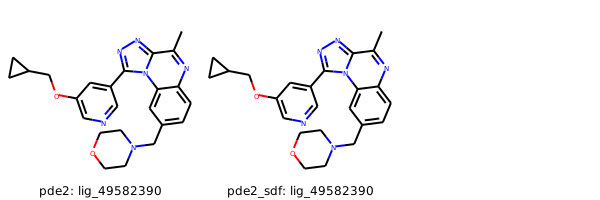

In [15]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
import rdkit.Chem.Draw as D
rdkitMols = []
for i, (target, ligand) in enumerate(np.unique(differing_molecules, axis=0)):
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligPath = 'systems/' + target + '/' + ligand + '/' + ligand
        
    if os.path.isfile(ligPath+'.sdf'):
        print('-' * 60)
        print('--- ' + ligand + ' ---')
        print('-' * 60)
        mols = AllChem.SDMolSupplier(ligPath+'.sdf')
        for mol in mols:
            AllChem.Compute2DCoords(mol)
            mol.SetProp('_Name', target + ': ' + ligand)
            rdkitMols.append(mol)
    for k, item in energies[target][ligand].items():
        print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(k, item[0], item[1], item[2]))
Draw.MolsToGridImage(rdkitMols, legends=[x.GetProp('_Name') for x in rdkitMols])

#### Minimized Energies

In [16]:
minEnergies={}
print('    {:20s}: {:15s}    {:15s}    {:15s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    minEnergies[target] = {}
    for key in openmmMinimizedEnergies[target].keys():
        print(key)
        minEnergies[target][key] = {}
        for kk, ene in openmmMinimizedEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsMinimizedEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Proper Dih.']
                if 'Improper Dih.' in gromacsMinimizedEnergies[target][key].keys():
                    print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format('ImproperTorsionForce', 0.0, gromacsMinimizedEnergies[target][key]['Improper Dih.'], -gromacsMinimizedEnergies[target][key]['Improper Dih.']))
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Potential']
            else:
                print('Error: OpenMM Energy not known.')
            minEnergies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM             Gromacs            Difference     
=== testmols ===
acetone
    HarmonicBondForce   :     3.18286e-02        2.51402e-01       -2.19573e-01
    HarmonicAngleForce  :     3.78983e-02        3.20018e+00       -3.16228e+00
    PeriodicTorsionForce:     2.00520e+01        2.18385e+01       -1.78649e+00
    NonbondedForce      :    -9.40043e+01       -9.47708e+01        7.66487e-01
    TotalPotential      :    -7.38826e+01        0.00000e+00       -7.38826e+01
benzaldehyde
    HarmonicBondForce   :     9.39534e-01        3.52264e+00       -2.58311e+00
    HarmonicAngleForce  :     3.03195e-01        8.67769e-01       -5.64574e-01
    PeriodicTorsionForce:     1.54672e-04        7.13206e-03       -6.97739e-03
    NonbondedForce      :     5.44286e+01        5.55265e+01       -1.09792e+00
    TotalPotential      :     5.56715e+01        0.00000e+00        5.56715e+01
benzene
    HarmonicBondForce   :     4.95960e-01        7.65785e-01       -2.6982

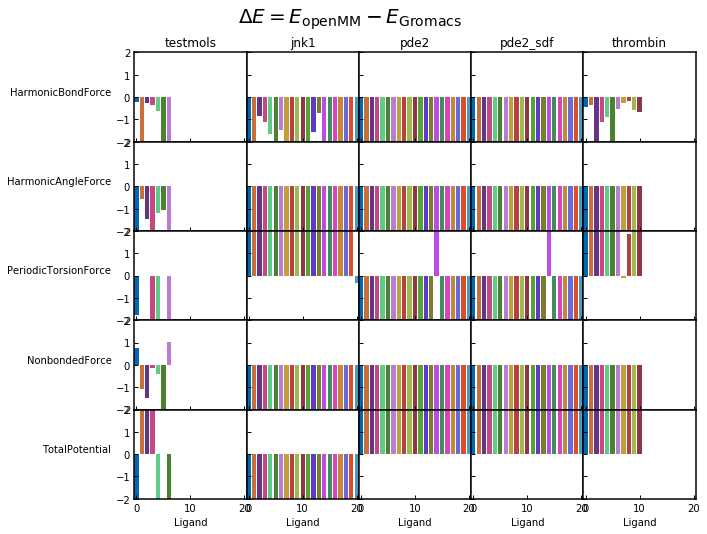

In [17]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(minEnergies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], minEnergies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], minEnergies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_minimized_differences_openmm_gromacs.png')
plt.show()

# Calculate RMSD between the minimized structures 
So far without roto-translational alignment

In [18]:
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'_minimized.pdb') and os.path.isfile(ligPath+'_em.gro'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gromacs_positions = pmd.load_file(ligPath+'_em.gro')
            openmm_positions = pmd.load_file(ligPath+'_minimized.pdb')
#             print(type(gromacs_positions.positions.value_in_unit(unit.nanometer)), type(openmm_positions.positions.value_in_unit(unit.nanometer)))
#             print(gromacs_positions.positions.value_in_unit(unit.nanometer), openmm_positions.positions.value_in_unit(unit.nanometer))
#             print(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer)))
#             print(np.square(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer))))
            squared_distances = np.sum(np.square(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer))), axis = 1)
#             print(squared_distances)
            print('    RMSD: {:.4f} nm'.format(np.sqrt(squared_distances.sum()/squared_distances.shape[0])))  

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    RMSD: 0.2866 nm
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
    RMSD: 0.3652 nm
------------------------------------------------------------
--- benzene ---
------------------------------------------------------------
    RMSD: 0.3739 nm
------------------------------------------------------------
--- ethane ---
------------------------------------------------------------
    RMSD: 0.2221 nm
------------------------------------------------------------
--- ethanol ---
------------------------------------------------------------
    RMSD: 0.2260 nm
------------------------------------------------------------
--- methane ---
------------------------------------------------------------
    RMSD: 0.1034 nm
-------------------------------

    RMSD: 0.0868 nm
=== thrombin ===
------------------------------------------------------------
--- lig_1a ---
------------------------------------------------------------
    RMSD: 0.1489 nm
------------------------------------------------------------
--- lig_1b ---
------------------------------------------------------------
    RMSD: 0.1526 nm
------------------------------------------------------------
--- lig_1c ---
------------------------------------------------------------
    RMSD: 0.1498 nm
------------------------------------------------------------
--- lig_1d ---
------------------------------------------------------------
    RMSD: 0.1073 nm
------------------------------------------------------------
--- lig_3a ---
------------------------------------------------------------
    RMSD: 0.1694 nm
------------------------------------------------------------
--- lig_3b ---
------------------------------------------------------------
    RMSD: 0.1954 nm
---------------------